In [1]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

2022-04-19 02:11:06.436532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


2022-04-19 02:11:17.843681: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-19 02:11:17.844363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-19 02:11:17.930194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 02:11:17.930820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-19 02:11:17.930879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-19 02:11:18.249711: I tensorflow/stream_executor/platform/defa

In [3]:
SEED = 1000
IMG_SIZE = 224
BATCH_SIZE = 64

TRAIN_DIR = '/home/dev/Documents/datasets/CUB_200_2011/images'

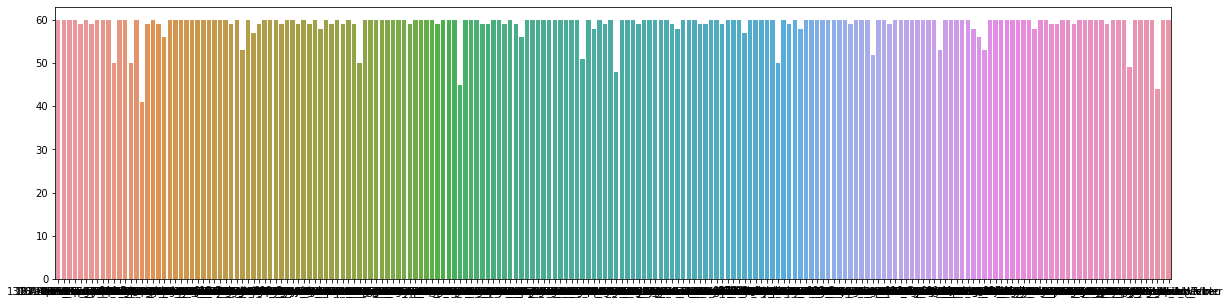

In [4]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [5]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [6]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'categorical',
    seed=SEED
)

Found 8284 images belonging to 200 classes.


In [7]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'categorical',
    seed=SEED
)

Found 3504 images belonging to 200 classes.


In [8]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

2022-04-19 02:11:43.531500: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 02:11:43.533256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 02:11:43.534929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-19 02:11:43.535047: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [10]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [11]:
base_model.trainable = False

In [12]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)


outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#     loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

In [14]:
h = model.fit(train_batch, 
              epochs=100,
              steps_per_epoch = 8284 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 3504 // BATCH_SIZE,
              callbacks=[cb, reduce_lr]
             )

2022-04-19 02:13:44.689095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-19 02:13:44.754930: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/100


2022-04-19 02:13:50.348223: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-19 02:13:53.822551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-19 02:14:01.294888: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-04-19 02:14:01.324320: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-19 02:14:10.410063: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the av

129/129 [==============================] - 310s 2s/step - loss: 5.7532 - accuracy: 0.0065 - val_loss: 5.1694 - val_accuracy: 0.0252
Epoch 2/100
129/129 [==============================] - 149s 1s/step - loss: 5.2809 - accuracy: 0.0263 - val_loss: 4.8489 - val_accuracy: 0.0723
Epoch 3/100
129/129 [==============================] - 155s 1s/step - loss: 4.8962 - accuracy: 0.0579 - val_loss: 4.5130 - val_accuracy: 0.1152
Epoch 4/100
129/129 [==============================] - 156s 1s/step - loss: 4.6543 - accuracy: 0.0890 - val_loss: 4.2729 - val_accuracy: 0.1484
Epoch 5/100
129/129 [==============================] - 156s 1s/step - loss: 4.3598 - accuracy: 0.1228 - val_loss: 4.0889 - val_accuracy: 0.1730
Epoch 6/100
129/129 [==============================] - 156s 1s/step - loss: 4.1743 - accuracy: 0.1588 - val_loss: 3.9275 - val_accuracy: 0.2040
Epoch 7/100
129/129 [==============================] - 155s 1s/step - loss: 3.9935 - accuracy: 0.1802 - val_loss: 3.7864 - val_accuracy: 0.2242
Epoc

129/129 [==============================] - 157s 1s/step - loss: 2.0246 - accuracy: 0.5630 - val_loss: 2.3031 - val_accuracy: 0.4676
Epoch 57/100
129/129 [==============================] - 157s 1s/step - loss: 1.9975 - accuracy: 0.5716 - val_loss: 2.3189 - val_accuracy: 0.4627
Epoch 58/100
129/129 [==============================] - 156s 1s/step - loss: 2.0301 - accuracy: 0.5546 - val_loss: 2.3192 - val_accuracy: 0.4673
Epoch 59/100
129/129 [==============================] - 156s 1s/step - loss: 2.0281 - accuracy: 0.5519 - val_loss: 2.3189 - val_accuracy: 0.4621
Epoch 60/100
129/129 [==============================] - 157s 1s/step - loss: 2.0103 - accuracy: 0.5629 - val_loss: 2.3226 - val_accuracy: 0.4595
Epoch 61/100
129/129 [==============================] - 157s 1s/step - loss: 2.0131 - accuracy: 0.5651 - val_loss: 2.3176 - val_accuracy: 0.4676
Epoch 62/100
129/129 [==============================] - 157s 1s/step - loss: 2.0117 - accuracy: 0.5655 - val_loss: 2.3048 - val_accuracy: 0.463

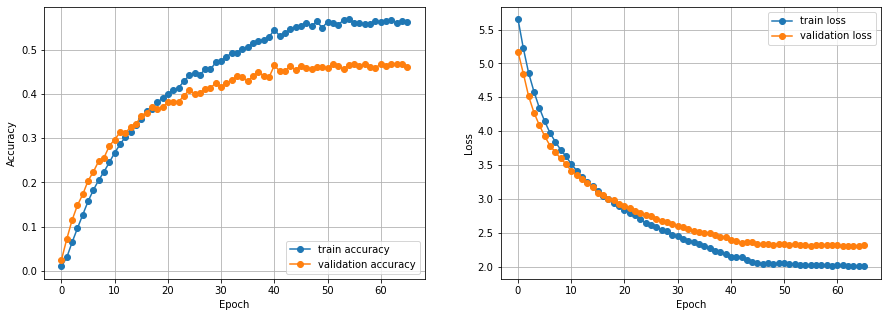

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [16]:
model.save('./ResNet152V2.h5')